In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import matplotlib.dates as mdates
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct, and_

In [5]:
#Create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#Declare a base using automap_base
Base=automap_base()

In [7]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# reflect the tables
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# We can view all of the classes that automap found
# Save references to each table
Measurement=Base.classes.measurement

In [9]:
Station=Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session=Session(engine)

#display first row in measurement
Data = session.query(Measurement).first()
Data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a758598518>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
current_date_str=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
current_date_str
current_date=datetime.strptime(current_date_str,'%Y-%m-%d' )
current_date
# Calculate the date 1 year ago from the last data point in the database
previous_date= current_date-relativedelta(years=1)
previous_date

datetime.datetime(2016, 8, 23, 0, 0)

In [12]:
# Perform a query to retrieve the date and precipitation scores
date_prcp_scores=session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>previous_date).all()            
                     
measurement_df =pd.DataFrame(date_prcp_scores)
#measurement_df.head()
measurement_df = measurement_df.set_index('date')
measurement_df = measurement_df.dropna()
measurement_df=measurement_df.sort_values(by = ['date'], ascending=True)
measurement_df


,prcp
date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


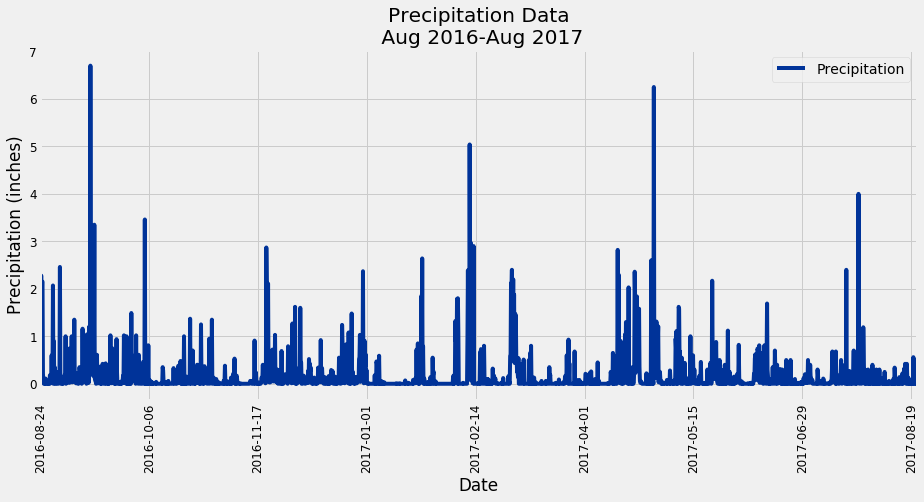

In [13]:
ax = measurement_df.plot( figsize=(14,6)
                         ,title='Precipitation Data\n Aug 2016-Aug 2017'
                         ,grid=True
                         ,color='#003399'
                         ,rot='90'
                         ,fontsize=12
) 

ax.set_xlabel('Date') 
ax.set_ylabel('Precipitation (inches)') 
ax.legend(['Precipitation'])

# Save the generated plot to an image file
plt.savefig( './output/fig01-precipitation.png'
            ,format='png'
            ,bbox_inches='tight'
            ,dpi=300
)  

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(distinct(Measurement.station)))
station_count[0]


(9)

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations= session.query(Measurement.station,func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#from the above dataset, we need to get the first record(ordered in descending) to get the
#station id.
dict_active_station= active_stations[0]._asdict()
dict_active_station

most_active_stationID = dict_active_station.get('station')
most_active_stationID



# qry = session.query(func.max(Player.score).label("max_score"), 
#                 func.min(Player.score).label("min_score"),
#                 )


'USC00519281'

In [18]:
##
#Use the above station id to get the min, max, and average temperature
result = session.query(func.max(Measurement.tobs).label('Maximum_Temperature')\
                         ,func.min(Measurement.tobs).label('Minimum_Temperature')\
                       ,func.avg(Measurement.tobs).label('Average_Temperature') )\
            .filter(Measurement.station ==most_active_stationID)
result

In [19]:
##
#print max, min , and avg temperature
res = result.one()
print(res.Maximum_Temperature)
print(res.Minimum_Temperature)
print(res.Average_Temperature)


85.0
54.0
71.66378066378067


In [20]:
# Choose the station with the highest number of temperature observations.

station_temp_obs= session.query(Measurement.station,func.count(Measurement.tobs))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.tobs).desc()).all()
station_temp_obs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
##Get the station id for maximum temperature observations
dict_most_temp_station= station_temp_obs[0]._asdict()
dict_most_temp_station

most_temp_stationID = dict_most_temp_station.get('station')
most_temp_stationID

'USC00519281'

In [22]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
##
# temp_data_19281=session.query(Measurement.date, Measurement.tobs)\
# .filter(Measurement.station==most_temp_stationID)\
# .filter(Measurement.date>previous_date).all()  

temp_data=session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==most_temp_stationID)\
            .filter(Measurement.date>previous_date).all()

temp_data

##Creating the data frame for temperature observation for Station ID USC00519281
                     
temp_df =pd.DataFrame(temp_data)
temp_df.shape

(351, 2)

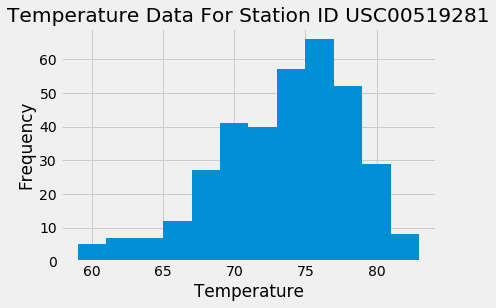

In [42]:
##
#plotting the 12 month temperature data as a histogram

# data = pd.cut(temp_df['tobs'], bins=12)
plt.hist(temp_df['tobs'],bins = 12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Data For Station ID USC00519281')
plt.savefig("output/fig02_station_histogram.png")




## Bonus Challenge Assignment

### Temperature Analysis I

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December:

In [24]:
df_weatherdata = pd.read_csv('Resources/hawaii_measurements.csv')
df_weatherdata
df_weather_june_only = df_weatherdata.loc[df_weatherdata['date'].str.contains('-06-', case=False, regex=True, na=False)]
df_weather_dec_only = df_weatherdata.loc[df_weatherdata['date'].str.contains('-12-', case=False, regex=True, na=False)]
#Now find the average tempreature in June
June_Average = df_weather_june_only['tobs'].mean()
Dec_Average = df_weather_dec_only['tobs'].mean()


In [25]:
# June average for all stations is :
June_Average

74.94411764705882

In [26]:
# December average for all stations is :
Dec_Average

71.04152933421226

In [27]:
# Since the weather in month of June and December are not related to each other , we should do an unpaired t-test
from scipy import stats
stats.ttest_ind(df_weather_june_only['tobs'], df_weather_dec_only['tobs'],equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

### Temperature Analysis II

In [28]:
from datetime import datetime
from flask import jsonify
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start, end):
#     """TMIN, TAVG, and TMAX for a list of dates.    
#     Args:
#         start_date (string): A date string in the format %Y-%m-%d
#         end_date (string): A date string in the format %Y-%m-%d
        
#     Returns:
#         TMIN, TAVE, and TMAX
#     """
    date_format = '%Y-%m-%d'
    try:
        date_start = datetime.strptime(start, date_format)
        date_end = datetime.strptime(end, date_format)
    except ValueError:
#   ("Incorrect data format, should be YYYY-MM-DD")
     return 'Incorrect date format, should be YYYY-MM-DD'
    # Create our session (link) from Python to the DB
    session = Session(engine)
    result = session.query(func.min(Measurement.tobs).label("Minimum_Tempreature"),
                       func.avg(Measurement.tobs).label("Average_Tempreature"),
                       func.max(Measurement.tobs).label("Maximum_Tempreature"),).filter(and_( Measurement.date >= date_start ,Measurement.date <= date_end))
#     for row in result:
#         return(row._asdict())    
    return result.one()


In [29]:
start=str(input('Enter the start date in YYYY-MM-DD '))
end = str(input('Enter the end date in YYYY-MM-DD '))
calc_temps(start,end)


Enter the start date in YYYY-MM-DD 2016-08-23
Enter the end date in YYYY-MM-DD 2017-08-24


(58.0, 74.57894736842105, 87.0)

In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps('2017-03-06','2017-08-23')
tmin


58.0

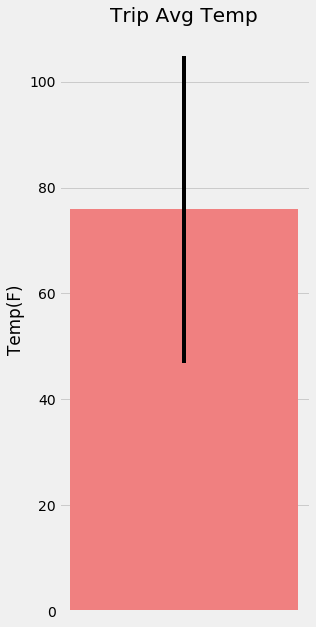

In [40]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr=tmax-tmin
fig, ax = plt.subplots(figsize=plt.figaspect(2.5))
x = 1
ax.set(xticks=range(x), ylabel= 'Temp(F)',title= 'Trip Avg Temp')
plot_1 = ax.bar(x,tavg, yerr=yerr, color ='lightcoral' )
plt.savefig("output/tempreature.png")

### Daily Rainfall Average

In [32]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# first create a dataframe for station
df_station = pd.read_csv('Resources/hawaii_stations.csv')

# Now merge both the dataframes and select the columns
df_merged_data = pd.merge(df_station, df_weatherdata, how='outer', on=['station'])
df_merged_data.head(10)




,station,name,latitude,longitude,elevation,date,prcp,tobs
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-01,0.08,65
1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-02,0.00,63
2,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-03,0.00,74
3,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-04,0.00,76
4,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-06,NaN,73
5,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-07,0.06,70
6,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-08,0.00,64
7,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-09,0.00,68
8,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-10,0.00,73
9,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-11,0.01,64


In [33]:
df_merged_data['date'] = pd.to_datetime(df_merged_data['date'], infer_datetime_format=True)
df_oneyeardata = df_merged_data.loc[(df_merged_data['date'] > '2016-08-23') & (df_merged_data['date'] <= '2017-08-23')]
df_oneyeardata = df_oneyeardata.dropna()
df_oneyeardata

df_precipitation = df_oneyeardata.groupby(['station']).agg(prcp_sum=('prcp', 'sum')).reset_index()
df_station_precipitation = pd.merge(df_precipitation, df_station, how='left', on=['station'])
df_station_precipitation 

df_station_precipitation = df_station_precipitation.sort_values(by=['prcp_sum'], ascending=[None])
df_station_precipitation

,station,prcp_sum,name,latitude,longitude,elevation
2,USC00516128,147.11,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00519281,68.24,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
0,USC00513117,48.36,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
6,USC00519523,37.99,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,USC00514830,33.19,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,USC00519397,16.09,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
3,USC00517948,4.59,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(singledate):
    """Daily Normals.    
    Args:
        date (str): A date string in the format '%m-%d'        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax    
    """
    # Create our session (link) from Python to the DB
    session = Session(engine)
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == singledate).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
date_input = str(input('Enter a date in MM-DD format'))
daily_normals(date_input)

Enter a date in MM-DD format08-23


[(67.0, 76.6923076923077, 87.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#2017-03-06-Start Date
#2017-08-23-End Date

# Use the start and end date to create a range of dates
start_date="2017-03-06"
end_date= "2017-08-23"
trip_dates=pd.date_range(start_date, end_date, freq='D')
trip_dates



DatetimeIndex(['2017-03-06', '2017-03-07', '2017-03-08', '2017-03-09',
               '2017-03-10', '2017-03-11', '2017-03-12', '2017-03-13',
               '2017-03-14', '2017-03-15',
               ...
               '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
               '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
               '2017-08-22', '2017-08-23'],
              dtype='datetime64[ns]', length=171, freq='D')

In [37]:
# Stip off the year and save a list of %m-%d strings
trip_dates_month=trip_dates.strftime('%m-%d')
trip_dates_month
normals=[]
# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_dates_month:
    normals.append(daily_normals(date)[0])
normals

[(60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0),
 (60.0, 69.89285714285714, 82.0),
 (62.0, 69.88888888888889, 80.0),
 (56.0, 69.29629629629629, 77.0),
 (62.0, 70.32758620689656, 77.0),
 (58.0, 68.54716981132076, 76.0),
 (60.0, 69.70370370370371, 78.0),
 (57.0, 68.54, 75.0),
 (57.0, 67.7843137254902, 76.0),
 (60.0, 69.1, 75.0),
 (62.0, 70.11764705882354, 80.0),
 (60.0, 71.07692307692308, 77.0),
 (65.0, 71.75471698113208, 77.0),
 (63.0, 70.79629629629629, 78.0),
 (62.0, 71.5, 77.0),
 (63.0, 71.5, 78.0),
 (64.0, 71.38, 80.0),
 (63.0, 71.53846153846153, 80.0),
 (59.0, 71.51785714285714, 82.0),
 (58.0, 71.35714285714286, 77.0),
 (62.0, 72.17543859649123, 79.0),
 (61.0, 71.875, 79.0),
 (60.0, 71.87931034482759, 80.0),
 (53.0, 71.82142857142857, 79.0),
 (55.0, 72.2280701754386, 78.0),
 (58.0, 72.01639344262296, 78.0),
 (61.0, 72.28813559322033, 80.0),
 (67.0, 71.57142857142

In [38]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normals = pd.DataFrame(normals,columns=['Minimum Temperature','Average Temperature','Maximum Temperature'])
df_normals['Date'] = trip_dates
df_normals=df_normals.set_index('Date')
df_normals

,Minimum Temperature,Average Temperature,Maximum Temperature
Date,,,
2017-03-06,60.0,69.203390,76.0
2017-03-07,60.0,69.172414,78.0
2017-03-08,59.0,68.724138,78.0
2017-03-09,57.0,68.561404,75.0
2017-03-10,57.0,69.122807,75.0
...,...,...,...
2017-08-19,69.0,75.946429,85.0
2017-08-20,68.0,76.452830,82.0
2017-08-21,67.0,76.400000,83.0


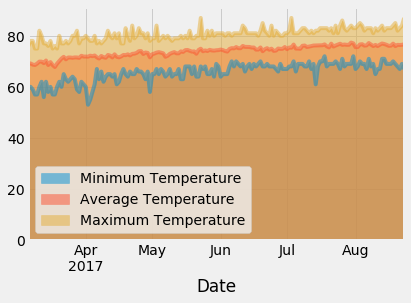

In [41]:
# Plot the daily normals as an area plot with `stacked=False`
ax.set(xticks=df_normals.index, ylabel= 'Temperature')
ax = df_normals.plot.area(stacked=False)
plt.savefig("output/fig04_precipitation.png")